In [1]:
from firedrake import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import GenericSolveBlock, ProjectBlock

In [2]:
import matplotlib.pyplot as plt

In [3]:
n = 100
l = 10.0
h = Constant(l/n)
mesh = IntervalMesh(n, l)
x, = SpatialCoordinate(mesh)

In [4]:
m_opt = 1.0
m_prior = 0.1

In [5]:
num_timesteps = 10
dt = Constant(0.1)

In [6]:
P2 = FunctionSpace(mesh, "CG", 1)
P1 = FunctionSpace(mesh, "CG", 1)
V = P2*P1
R = FunctionSpace(mesh, "R", 0)
Constant = lambda _: Function(R).assign(_)

In [7]:
u, eta = TrialFunctions(V)
z, zeta = TestFunctions(V)
m = Constant(m_prior)
c = Control(m)
eta0 = Function(P1)
eta0.interpolate(conditional(And(ge(x, 1), le(x, 2)), abs(sin(pi*x)), 0))
q_ = Function(V)
u_, eta_ = q_.split()
eta_.project(m*eta0);

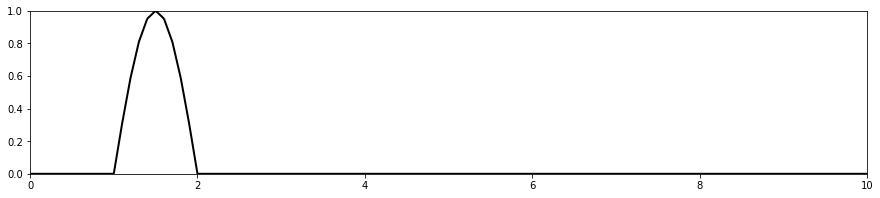

In [8]:
fig, axes = plt.subplots(figsize=(15, 3))
plot(eta0, axes=axes)
axes.set_xlim([0, l])
axes.set_ylim([0, 1]);

In [9]:
b = Constant(1.0)
g = Constant(9.81)

In [10]:
a = u*z*dx + eta*zeta*dx + dt*g*eta.dx(0)*z*dx - dt*b*u*zeta.dx(0)*dx
L = u_*z*dx + eta_*zeta*dx
q = Function(V)
u, eta = q.split()
bc = DirichletBC(V.sub(1), 0, 2)

In [11]:
P0 = FunctionSpace(mesh, "DG", 0)
k = Function(P0*P0)
ku, keta = k.split()
keta.interpolate(conditional(And(ge(x, 4), le(x, 4+h)), 1, 0))
qd = Function(V)
ud, etad = qd.split()
# J_form = dt*inner(k, q - qd)*inner(k, q - qd)*dx
# J_form = dt*inner(k, q - qd)*dx
J_form = 0.5*dt*keta*(eta - etad)**2*dx

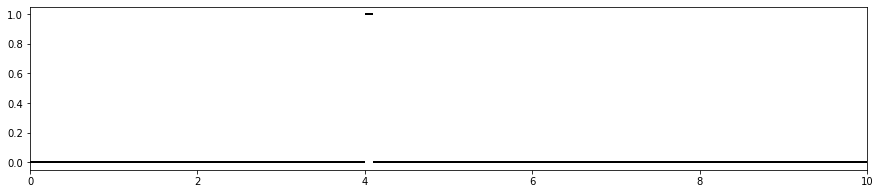

In [12]:
fig, axes = plt.subplots(figsize=(15, 3))
plot(keta, axes=axes)
axes.set_xlim([0, l]);

In [13]:
with stop_annotating():
    data = []
    m.assign(m_opt)
    for i in range(num_timesteps):
        solve(a == L, q, bcs=bc)
        q_.assign(q)
        data.append(assemble(keta*eta/h*dx))
    u_.assign(0.0)
    eta_.assign(eta0)
m.assign(m_prior);

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f511824f220>, FiniteElement('Real', interval, 0), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 1)), 4)

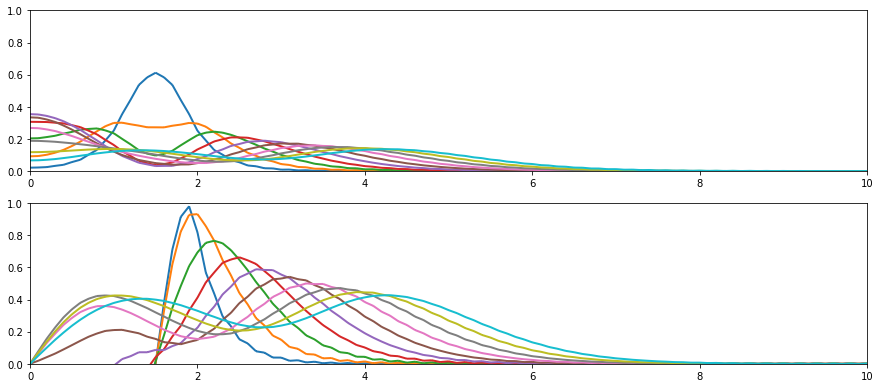

In [14]:
J = 0
fig, axes = plt.subplots(nrows=2, figsize=(15, 6.5))
solutions = []
for i in range(num_timesteps):
    solve(a == L, q, bcs=bc)
    q_.assign(q)
    solutions.append(q.copy(deepcopy=True))
    etad.assign(data[i])
    J += assemble(J_form)
    plot(eta, axes=axes[0], edgecolor=f"C{i}")
    plot(u, axes=axes[1], edgecolor=f"C{i}")
axes[0].set_xlim([0, l]);
axes[0].set_ylim([0, 1]);
axes[1].set_xlim([0, l]);
axes[1].set_ylim([0, 1]);

In [15]:
stop_annotating();

In [16]:
Jhat = ReducedFunctional(J, c)
gd = Jhat.derivative().dat.data[0]

In [17]:
tape = get_working_tape()
solve_blocks = [
    block
    for block in tape.get_blocks()
    if issubclass(type(block), GenericSolveBlock)
    and not issubclass(type(block), ProjectBlock)
]

In [18]:
phi = TestFunction(V)
cont_adj = Function(V)
cont_adj_ = Function(V)
a_star = adjoint(a)
# L_star = inner(phi, cont_adj_)*dx + derivative(J_form, eta, zeta)
L_star = inner(phi, cont_adj_)*dx + dt*keta*(eta - etad)*zeta*dx

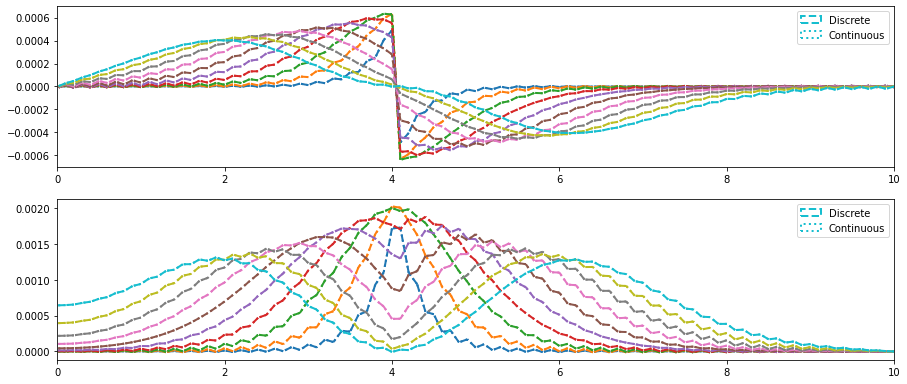

In [19]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 6.5))
for i in range(num_timesteps-1, -1, -1):
    colour = f"C{num_timesteps-1-i}"
    discrete_adj = solve_blocks[i].adj_sol
    plot(discrete_adj.split()[0], axes=axes[0], linestyle='--', edgecolor=colour, label='Discrete' if i == 0 else None)
    plot(discrete_adj.split()[1], axes=axes[1], linestyle='--', edgecolor=colour, label='Discrete' if i == 0 else None)
    cont_adj_.assign(cont_adj)
    etad.assign(data[i])
    q.assign(solutions[i])
    solve(a_star == L_star, cont_adj, bcs=bc)
    plot(cont_adj.split()[0], axes=axes[0], linestyle=':', edgecolor=colour, label='Continuous' if i == 0 else None)
    plot(cont_adj.split()[1], axes=axes[1], linestyle=':', edgecolor=colour, label='Continuous' if i == 0 else None)
axes[0].legend();
axes[1].legend();
axes[0].set_xlim([0, l]);
axes[1].set_xlim([0, l]);

In [20]:
gc = assemble(eta0*cont_adj.split()[1]*dx)

In [21]:
print(f"Discrete gradient   = {gd}")
print(f"Continuous gradient = {gc}")

Discrete gradient   = 0.0007481070491078633
Continuous gradient = 0.0007481070491078632
